# Introduction

There are three major challenges regarding this set of data: 

1. The tasks have varying input and output sizes
2. There are very few training samples per task
3. It is difficult to generate new samples(to increase the size of the training set of each task) due to the abstract rules governing each input and output pair. 

In order to tackle the first challenge, the data will be zero-padded into square grids based on the largest input and output dimensions. For example, if the largest input dimension in a task is 15x20 and the largest output dimension is 30x20, the inputs will be zero-padded to a 20x20 grid, while the outputs will be padded into a 30x30 grid. This allows the same model to tackle the varying input sizes present in that particular task. 

Regarding the second challenge, two approaches will be taken. First, from the visual analysis, it was observed that the outputs are related to the inputs either by a transformation of the input data or by a set of spatial rules. Two models with the potential to capture these abstract rules are convolution neural networks(CNNs) and variational autoencoders(VAEs). 
The convolutional neural network may be able to capture the spatial patterns between the inputs and outputs.

VAE's on the other hand are a type of generative model that encodes the input as a distribution over a latent space. Hopefully the VAE will be able to *generate* outputs that are similar to the inputs but follow the same abstract rule through the task. 

In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd

from pathlib import Path
import json
import ast

In [2]:
training_path = Path('../Data/training')
evaluation_path = Path('../Data/evaluation')

In [3]:
task_summary = pd.read_csv('../Data/task_summary.csv')

exclude_cols = ['task_label', 'num_train']
list_cols = [col for col in task_summary.columns if col not in exclude_cols]

# convert objects within columns containing lists from strings to lists
for col in list_cols:
    task_summary[col] = task_summary[col].apply(ast.literal_eval)
    
task_summary.head()

,task_label,num_train,train_input_widths,train_input_heights,train_output_widths,train_output_heights,test_input_width,test_input_height,test_output_width,test_output_height,unique_colors
0,007bbfb7.json,5,"[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3]","[9, 9, 9, 9, 9]","[9, 9, 9, 9, 9]",[3],[3],[9],[9],"[0, 2, 4, 6, 7]"
1,00d62c1b.json,5,"[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]",[20],[20],[20],[20],"[0, 3, 4]"
2,017c7c7b.json,3,"[3, 3, 3]","[6, 6, 6]","[3, 3, 3]","[9, 9, 9]",[3],[6],[3],[9],"[0, 1, 2]"
3,025d127b.json,2,"[9, 9]","[14, 8]","[9, 9]","[14, 8]",[10],[10],[10],[10],"[0, 2, 4, 6, 8]"
4,045e512c.json,3,"[21, 21, 21]","[21, 21, 21]","[21, 21, 21]","[21, 21, 21]",[21],[21],[21],[21],"[0, 1, 2, 3, 4, 5, 6, 8]"


## Calculate maximum dimensions for each task 

In [4]:
def calc_max_dim(df, test_or_train):
    input_width_col = 'train_' + test_or_train + '_widths'
    input_height_col = 'train_' + test_or_train + '_heights'
    output_width_col = 'test_' + test_or_train + '_width'
    output_height_col = 'test_' + test_or_train + '_height'
    
    input_max_width = max(df[input_width_col])
    input_max_height = max(df[input_height_col])
    output_max_width = max(df[output_width_col])
    output_max_height = max(df[output_height_col])
    
    return max(input_max_width, input_max_height, output_max_width, output_max_height)

task_summary['max_input_dim'] = task_summary.apply(func=calc_max_dim, axis=1, args=('input',))
task_summary['max_output_dim'] = task_summary.apply(func=calc_max_dim, axis=1, args=('output',))

task_summary.head()

,task_label,num_train,train_input_widths,train_input_heights,train_output_widths,train_output_heights,test_input_width,test_input_height,test_output_width,test_output_height,unique_colors,max_input_dim,max_output_dim
0,007bbfb7.json,5,"[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3]","[9, 9, 9, 9, 9]","[9, 9, 9, 9, 9]",[3],[3],[9],[9],"[0, 2, 4, 6, 7]",3,9
1,00d62c1b.json,5,"[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]",[20],[20],[20],[20],"[0, 3, 4]",20,20
2,017c7c7b.json,3,"[3, 3, 3]","[6, 6, 6]","[3, 3, 3]","[9, 9, 9]",[3],[6],[3],[9],"[0, 1, 2]",6,9
3,025d127b.json,2,"[9, 9]","[14, 8]","[9, 9]","[14, 8]",[10],[10],[10],[10],"[0, 2, 4, 6, 8]",14,14
4,045e512c.json,3,"[21, 21, 21]","[21, 21, 21]","[21, 21, 21]","[21, 21, 21]",[21],[21],[21],[21],"[0, 1, 2, 3, 4, 5, 6, 8]",21,21


## Model Building

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Lambda
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K


import matplotlib.pyplot as plt
from matplotlib import colors 

In [6]:
# Set index of task summary data frame to task_label for ease of indexing 
task_summary.set_index('task_label', inplace=True)

In [7]:
def pad_samples(group, max_input_dim, max_output_dim):
    padded_inputs = []
    padded_outputs = []
    
    for io_pair in group: 
        sample_input = io_pair['input'] 
        sample_output = io_pair['output']

        input_width = len(io_pair['input'][0])  
        input_height = len(io_pair['input'])

        output_width = len(io_pair['output'][0])
        output_height = len(io_pair['output'])

        input_row_padding = max_input_dim - input_height
        input_col_padding = max_input_dim - input_width

        output_row_padding = max_output_dim - output_height
        output_col_padding = max_output_dim - output_width

        padded_input = np.pad(sample_input, ((0, input_row_padding), (0, input_col_padding)), 'constant')
        padded_output = np.pad(sample_output, ((0, output_row_padding), (0, output_col_padding)), 'constant')

        padded_input = padded_input.reshape(1, max_input_dim, max_input_dim)
        padded_output = padded_output.reshape(1, max_output_dim, max_output_dim)
        
        padded_inputs.append(padded_input)
        padded_outputs.append(padded_output)
        
    padded_inputs = np.array(padded_inputs)
    padded_outputs = np.array(padded_outputs)
    
    return padded_inputs, padded_outputs

In [8]:
cmap = colors.ListedColormap(
       ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_grid(grid, ax, title, size):
    ax.imshow(grid, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(grid))])
    ax.set_xticks([x-0.5 for x in range(1+len(grid[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title, size=size)

### Convolutional Neural Network Approach

Due to the size of the data, and computational limits, only the first 10 tasks are completed and scored. 

Average accuracy over all tasks: 0.0


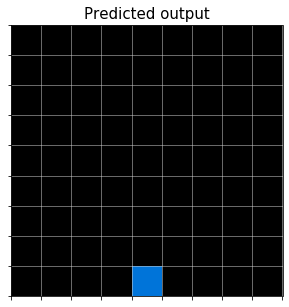

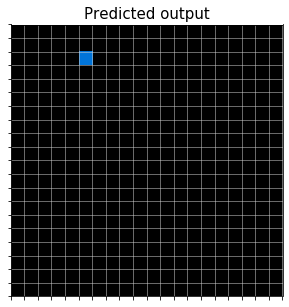

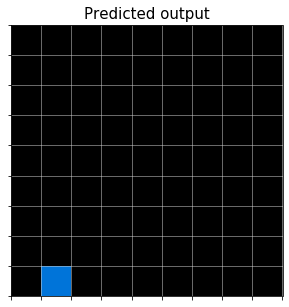

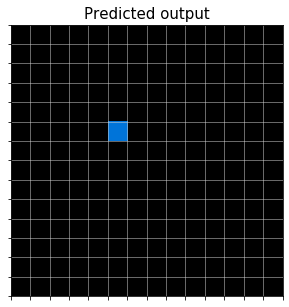

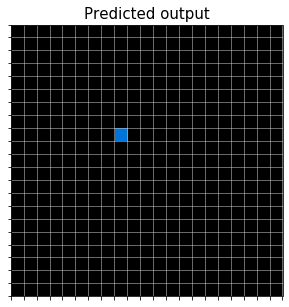

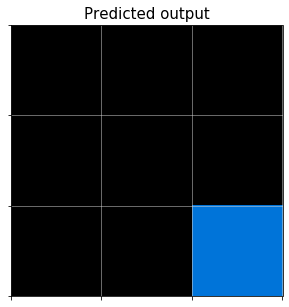

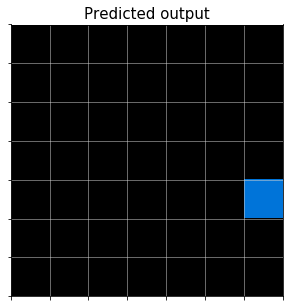

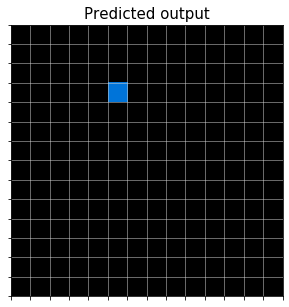

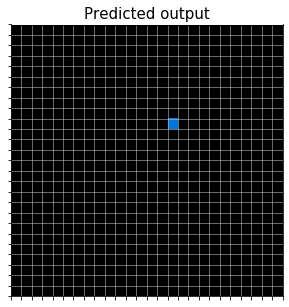

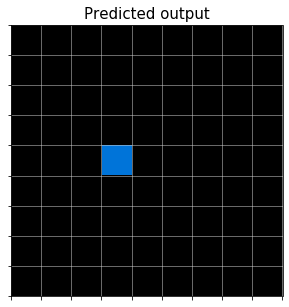

In [9]:
training_tasks = training_path.glob('**/*.json')

# -----------------------------------------------------------
# used to verify that the samples are all padded correctly
# -----------------------------------------------------------
# shape_equal = []
# -----------------------------------------------------------

# Code which would have been used to iterate over all training tasks
# for path in training_task_paths:
#     task_path_str = str(path)
#     task_file_name = task_path_str.split("\\")[-1]

acc_lst = []

for i in range(10):
    current_task = next(training_tasks)
    current_task_str = str(current_task)

    current_file_name = current_task_str.split("\\")[-1]

    max_input_dim, max_output_dim = task_summary.loc[current_file_name, ['max_input_dim', 'max_output_dim']]

    max_input_dim = max(10, max_input_dim)

    with open(current_task_str, 'r') as f:
        task = json.load(f)

    train = task['train']
    test = task['test']

    # Preprocessing 
    X_train, y_train = pad_samples(train, max_input_dim, max_output_dim)   
    X_test, y_test = pad_samples(test, max_input_dim, max_output_dim)

    # Reshape 
    y_train = np.array([array.flatten() for array in y_train])
    y_test = np.array([array.flatten() for array in y_test])

    output_size = len(y_train[0])
    input_shape = (1, max_input_dim, max_input_dim)
    
# -----------------------------------------------------------
#     used to verify that samples are padded correctly       
# -----------------------------------------------------------
#     shape_lst = []
#     for array in padded_train_outputs: 
#         shape_lst.append(array.shape)

#     shape_equal.append(checkEqual2(shape_lst))

# False in shape_equal
# -----------------------------------------------------------

    # Model Definition 
    batch_size = 1 
    epochs = 100

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(1, max_input_dim, max_input_dim), 
                     data_format='channels_first'))

    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax'))
        
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_test, y_test))

    score = model.evaluate(X_test.astype('float64'), y_test, verbose = 0)
    acc_lst.append(score[1])
    
    
    prediction = model.predict(X_test.astype('float64'))
    prediction = prediction.reshape(max_output_dim, max_output_dim)   
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_grid(prediction, ax, "Predicted output", 15)
    
print(f"Average accuracy over all tasks: {np.mean(acc_lst)}")

### Variational Autoencoder Approach

In [10]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

In [11]:
training_tasks = training_path.glob('**/*.json')

acc_lst = []

current_task = next(training_tasks)
current_task_str = str(current_task)

current_file_name = current_task_str.split("\\")[-1]

max_input_dim, max_output_dim = task_summary.loc[current_file_name, ['max_input_dim', 'max_output_dim']]

max_input_dim = max(10, max_input_dim)

with open(current_task_str, 'r') as f:
    task = json.load(f)

train = task['train']
test = task['test']

# Preprocessing 
X_train, y_train = pad_samples(train, max_input_dim, max_output_dim)   
X_test, y_test = pad_samples(test, max_input_dim, max_output_dim)

original_dim = max_input_dim * max_input_dim

X_train = np.reshape(X_train, [-1, original_dim])
X_test = np.reshape(X_test, [-1, original_dim])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# network parameters
input_shape = (original_dim, )
intermediate_dim = 256
batch_size = 1
latent_dim = 2
epochs = 50

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
print()
decoder.summary()
print()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

reconstruction_loss = binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')

vae.fit(X_train, 
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, None))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 256)          25856       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         dense_20[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         dense_20[0][0]                   
____________________________________________________________________________________________